## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, 
                              AdaBoostClassifier, BaggingClassifier, StackingClassifier)
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, log_loss, classification_report, 
                             roc_auc_score, ConfusionMatrixDisplay, confusion_matrix)
from imblearn.over_sampling import SMOTE


from sklearn.impute import SimpleImputer

sklearn.set_config(display='diagram')
%matplotlib inline

# Load Data and Train-Test-Split

In [4]:
# Load Meta Data
meta_data = pd.read_csv('data/train.csv')

# Load Data
signs = pd.read_csv('data/all_targets.csv',index_col=0)['0'].to_list()
signs_5 = ['hungry','stay','drink','dad','sad']
dataset_5_signs = pd.read_csv('data/dataset_hungry_stay_drink_dad_sad.csv', index_col=0)
dataset = pd.concat((dataset_5_signs,
                     pd.read_csv('data/dataset_round2_155.csv',index_col=0)), 
                    axis=0)
# Load sign name to int mapping
with open('data/sign_to_prediction_index_map.json') as f:
    sign_map = json.load(f)

# fix columns name ordering from data preprocessing
col_names_fixed = pd.read_csv('data/col_names_fixed.csv', index_col=0)['0'].values
dataset_5_signs.rename(columns={old:new for old, new in zip(dataset_5_signs.columns,col_names_fixed)}, inplace=True)
dataset

# Train Test Split 5 signs
X = dataset_5_signs.drop(columns='sign')
y = dataset_5_signs['sign'].map({sign:i for i, sign in enumerate(signs_5)})
X_train_5_signs, X_test_5_signs, y_train_5_signs, y_test_5_signs = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)
print(X_train_5_signs.shape, X_test_5_signs.shape, y_train_5_signs.shape, y_test_5_signs.shape)

# Train Test Split 87 signs
X = dataset.drop(columns='sign')
y = dataset['sign'].map({sign:i for i, sign in enumerate(signs)})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(1447, 2172) (483, 2172) (1447,) (483,)


((45390, 2172), (15130, 2172), (45390,), (15130,))

<function matplotlib.pyplot.show(close=None, block=None)>

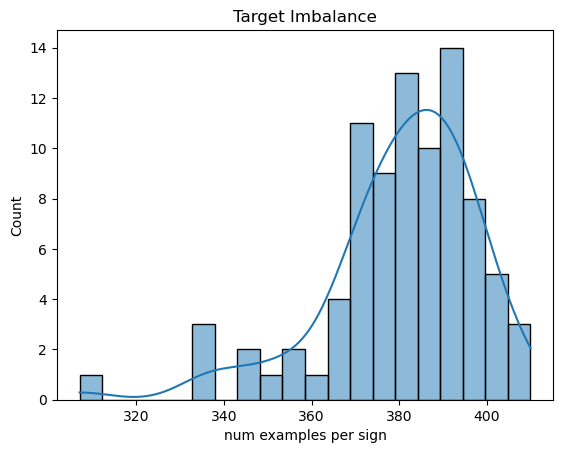

In [ ]:
sns.histplot(meta_data.loc[[sign in signs for sign in meta_data.sign]].sign.value_counts(), kde=True, bins=20)
plt.xlabel('number of examples per sign')
plt.title('Target Imbalance')
plt.show

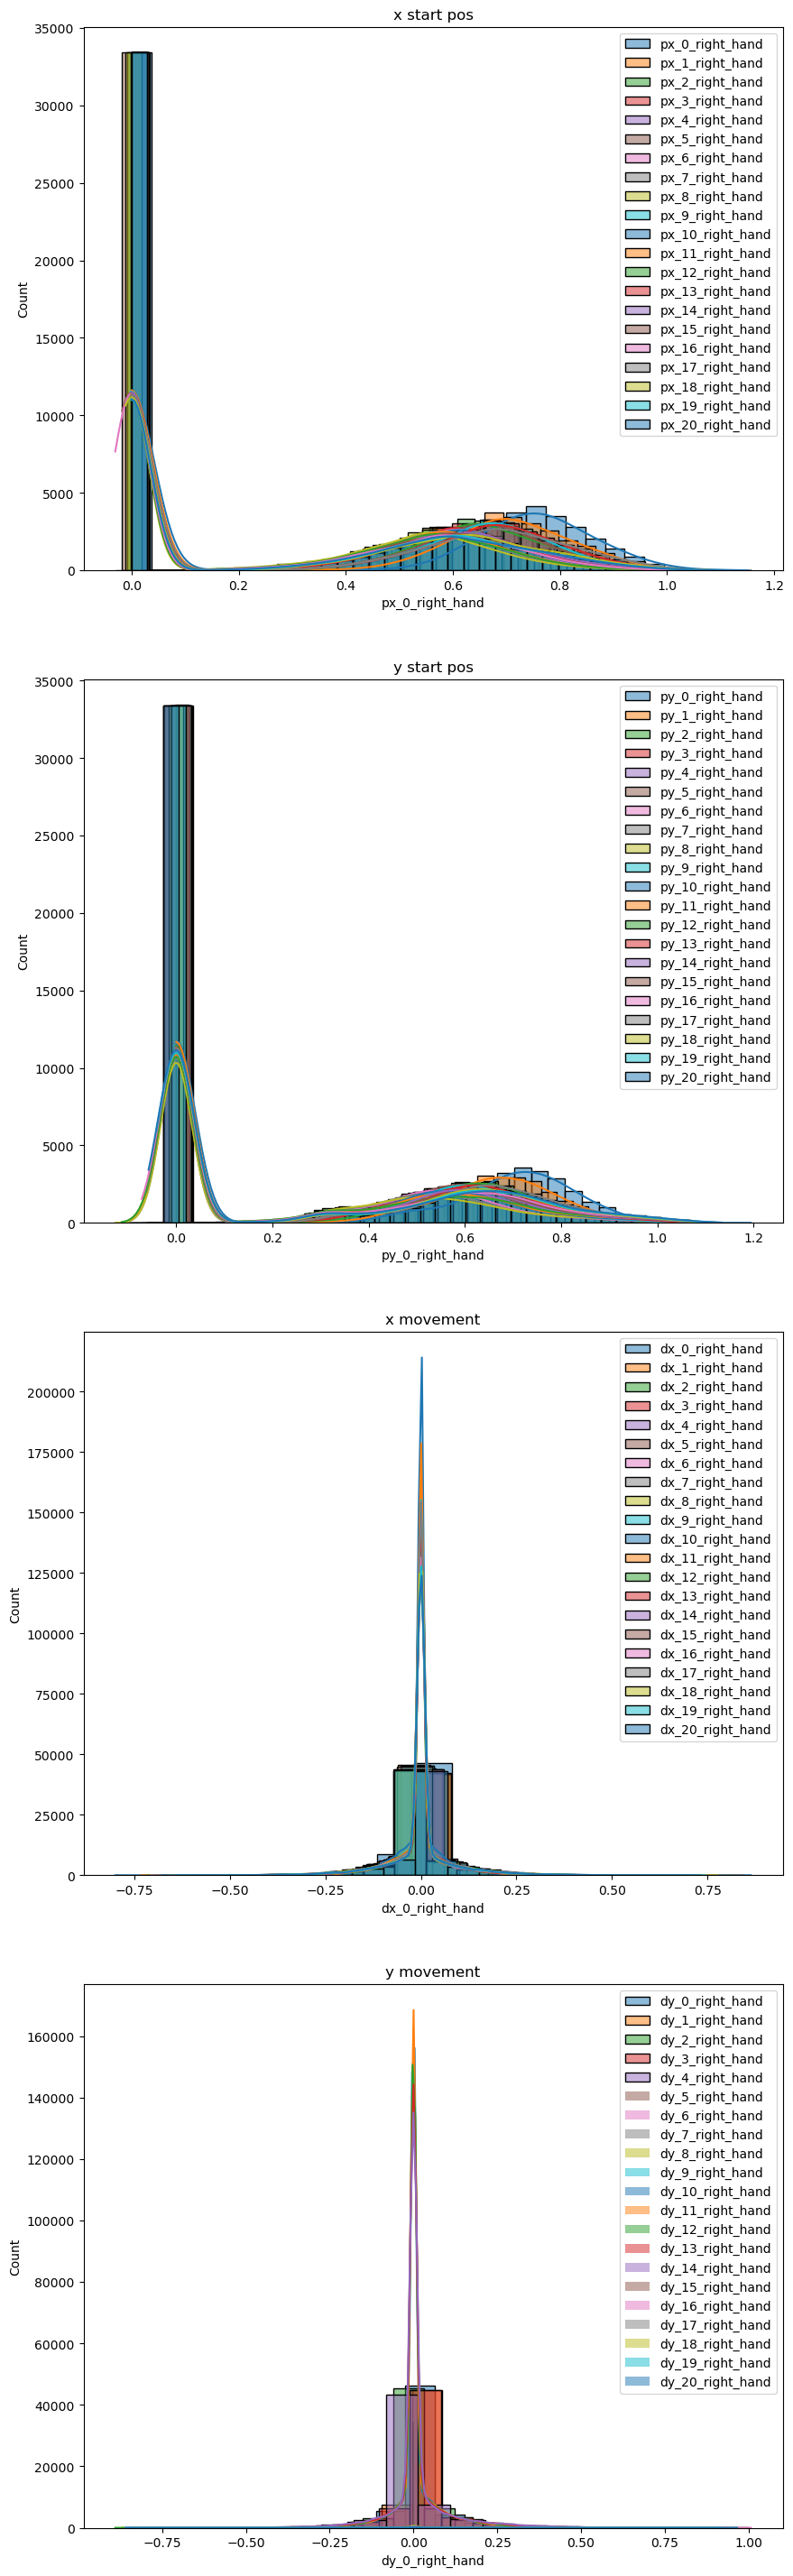

In [378]:
rh = dataset[dataset.columns[2088:-1]]
fig, ax = plt.subplots(nrows=4,figsize=(10,36))
titles= ['x start pos','y start pos', 'x movement','y movement']
for ax_index in range(len(ax)):
    for i in range(len(rh.columns)//4):
        sns.histplot(x=rh.columns[(i*4)+ax_index], data=rh, label=rh.columns[(i*4)+ax_index], kde=True,ax=ax[ax_index])
    ax[ax_index].set_title(titles[ax_index])
    ax[ax_index].legend()
plt.show()

# Load Model

In [467]:
hxgb_final_model = XGBClassifier(n_estimators = 300,
                                 colsample_bytree=1,
                                 max_depth = 4,
                                 subsample = 1,
                                 tree_method='gpu_hist',
                                 max_bin=64,
                                 predictor='gpu_predictor',
                                 verbosity=3,
                                 random_state=42)
hxgb_final_model.load_model('models/hxgb_final_fitted.model')
hxgb_pred = hxgb_final_model.predict(X_test)
display(hxgb_final_model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012, max_bin=64,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', ...)

# Confusion Matrix

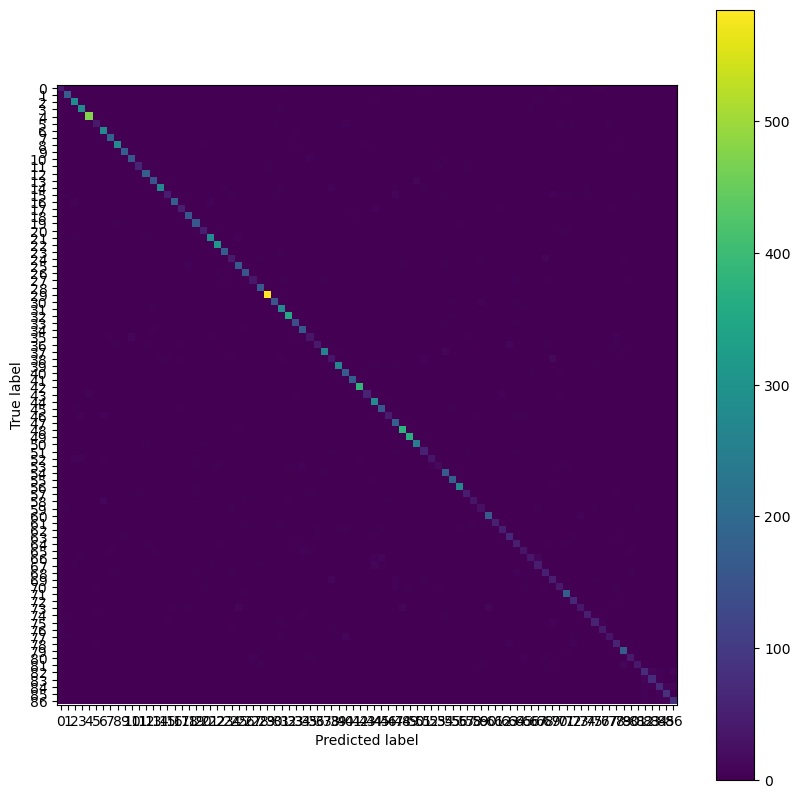

In [331]:
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, hxgb_pred, include_values=False,ax=ax)
plt.show()

In [5]:
cm = pd.DataFrame(confusion_matrix(y_test.map({i:sign for i, sign in enumerate(signs)}), 
                                   pd.Series(hxgb_pred).map({i:sign for i, sign in enumerate(signs)})),
                 index=signs,
                 columns=signs)
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    display(cm)

,pig,elephant,mad,finger,green,up,bad,bye,airplane,mom,kitty,home,yellow,shirt,talk,icecream,clown,lion,thirsty,book,dog,pretty,vacuum,chocolate,same,red,every,feet,drawer,gum,drop,story,puppy,haveto,zebra,cat,cow,dryer,old,garbage,stairs,cute,wolf,for,tree,sick,finish,bird,nose,no,have,blow,wet,give,dry,shower,another,bee,empty,night,cry,tiger,because,donkey,yes,yucky,why,morning,that,orange,where,tomorrow,uncle,mouth,farm,frog,table,helicopter,hear,yourself,find,girl,hungry,stay,drink,dad,sad
pig,283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
elephant,0,271,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mad,0,0,276,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
finger,0,3,1,49,1,2,1,0,0,0,0,0,3,1,0,0,1,2,1,0,1,2,1,0,0,2,1,0,0,0,0,1,0,3,0,1,1,0,0,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,4,3,0,0,0,0,0,0,2,0,0,1,1,0,0,0,1,0,0,0,2,0,1
green,1,1,2,1,46,0,1,4,2,4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2,0,1,0,0,0,0,0,2,0,0,0,4,1,3,0,0,2,0,1,2,1,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,0,1,0,2,0,0,2,0,0,1
up,0,0,2,0,0,180,2,2,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
bad,0,0,1,0,3,3,53,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,0,1,0,2,0,0,2,2,0,2,0,0,0,0,1,0,1,0,0,1,0,0,2,1,0,0,0,1,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,2,0,0,0,1,3,0,1,0
bye,4,4,0,2,0,0,0,162,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
airplane,0,0,0,2,2,0,0,2,181,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0
mom,0,0,0,2,4,0,0,0,3,35,1,2,1,1,0,0,1,1,0,0,0,1,0,2,2,1,2,0,2,0,0,0,1,0,0,0,1,0,0,3,5,1,2,0,0,8,0,0,0,0,0,0,1,0,0,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,2,0,0,1,1,2,1,0,0,0,1,0,0,1,0,1,2


# Report

In [469]:
hxgb_report = classification_report(y_test, hxgb_final_model.predict(X_test),target_names=signs, output_dict=True)
hxgb_metrics_df = pd.DataFrame(hxgb_report).transpose()

In [470]:
print('Mean Accuracy: ',hxgb_metrics_df['support']['accuracy'])
print('Mean Precision:',hxgb_metrics_df['precision']['macro avg'])
print('Mean Recall:   ',hxgb_metrics_df['recall']['macro avg'])
print('Mean f1-score: ',hxgb_metrics_df['f1-score']['macro avg'])
with pd.option_context('display.max_rows',None,'display.max_columns',None):
    display(hxgb_metrics_df.sort_values(by='recall',ascending=False)[['recall']].iloc[[3,9,12,22,30,33]])

Mean Accuracy:  0.8015862524785194
Mean Precision: 0.7349734200627183
Mean Recall:    0.6845124696429522
Mean f1-score:  0.6952299364721685


,recall
gum,1.000000
have,0.988142
bad,0.968085
clown,0.907216
red,0.884211
drawer,0.870968


# Feature Importance

In [190]:
hxgb_feat_imp = pd.DataFrame(hxgb_final_model.feature_importances_, index=col_names_fixed[:-1], columns=['importance']).reset_index()
hxgb_feat_imp['type'] = hxgb_feat_imp['index'].map(lambda x: x.split('_')[-1])
hxgb_feat_imp['kinematic'] = hxgb_feat_imp['index'].map(lambda x: x.split('_')[0][0])
hxgb_feat_imp['landmark'] = hxgb_feat_imp['index'].map(lambda x: int(x.split('_')[1]))
hxgb_feat_imp.rename(columns={'index':'id'}, inplace=True)
top_imp = hxgb_feat_imp.sort_values(by='importance', ascending=False).head(20)
top_imp

,id,importance,type,kinematic,landmark
988,px_193_face,0.007666,face,p,193
8,px_2_left_hand,0.007606,hand,p,2
2133,py_11_right_hand,0.005925,hand,p,11
278,dx_15_face,0.005531,face,d,15
430,dx_53_face,0.004529,face,d,53
313,py_24_face,0.004506,face,p,24
1669,py_363_face,0.004468,face,p,363
1857,py_410_face,0.004426,face,p,410
1424,px_302_face,0.004088,face,p,302
1611,dy_348_face,0.004004,face,d,348


# Landmark analysis

## Single Training Example Hungry

In [12]:
df

,frame,row_id,type,landmark_index,x,y,z
0,14,14-face-0,face,0,0.572878,0.578624,-0.046639
1,14,14-face-1,face,1,0.563819,0.617603,-0.072894
2,14,14-face-2,face,2,0.565945,0.604340,-0.041903
3,14,14-face-3,face,3,0.555285,0.649234,-0.048094
4,14,14-face-4,face,4,0.563864,0.628438,-0.076065
...,...,...,...,...,...,...,...
3253,19,19-right_hand-16,right_hand,16,0.411350,0.339473,-0.093045
3254,19,19-right_hand-17,right_hand,17,0.232389,0.398380,-0.125413
3255,19,19-right_hand-18,right_hand,18,0.355124,0.409858,-0.156586
3256,19,19-right_hand-19,right_hand,19,0.394198,0.366425,-0.138557


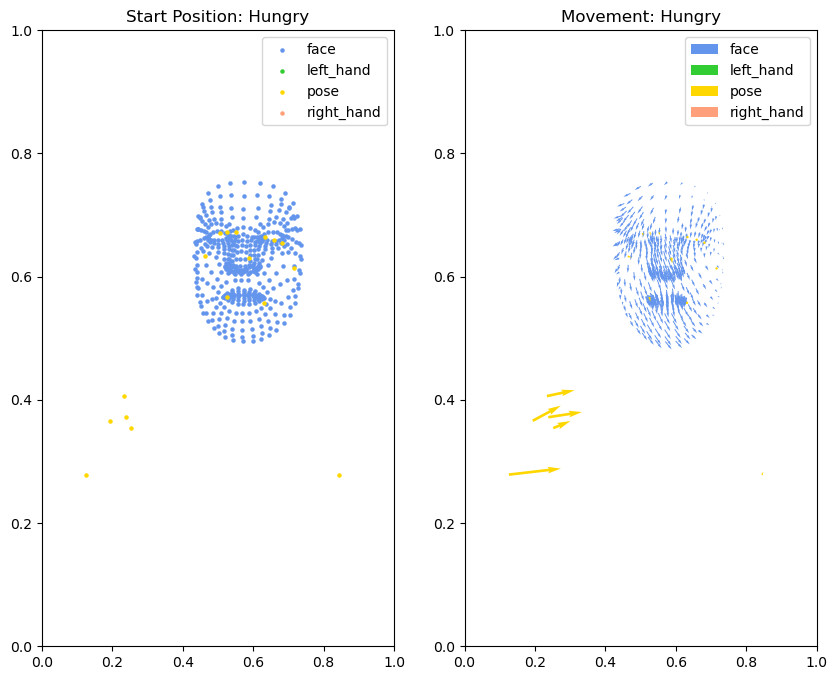

In [8]:
df = pd.read_parquet('data/1051788823.parquet')
df['y'] = 1-df['y']

fig, axes = plt.subplots(ncols=2,figsize=(10,8))
colors=['cornflowerblue','limegreen','gold','lightsalmon']
titles = ['Start Position: Hungry', 'Movement: Hungry']
ax_id = {'p':0,'d':1}

first_frame = df.loc[df.frame==df.frame.min()]
last_frame = df.loc[df.frame==df.frame.max()]

for i, type in enumerate(list(df.type.unique())):
    start = first_frame.loc[df.type == type]
    end = last_frame.loc[df.type == type]
    # Vector origin location
    X = start['x'].to_list()
    Y = start['y'].to_list()
    
    # Directional vectors
    U = np.array(end['x'].to_list()) - np.array(X)
    V = np.array(end['y'].to_list()) - np.array(Y)

    # Creating plot
    axes[0].scatter(X,Y, c=colors[i], label=type,s=5)
    axes[1].quiver(X, Y, U, V, color=colors[i], units='xy', scale=1, headwidth=2.5, label=type)

# for idx in top_imp.index:
#     feat = top_imp.loc[idx]
#     X = first_frame.loc[first_frame.landmark_index==feat['landmark']]['x'].values
#     Y = first_frame.loc[first_frame.landmark_index==feat['landmark']]['y'].values
#     U = last_frame.loc[last_frame.landmark_index==feat['landmark']]['x'].values - X
#     V = last_frame.loc[last_frame.landmark_index==feat['landmark']]['y'].values - Y
#     if feat['kinematic'] == 'p':
#         axes[ax_id[feat['kinematic']]].scatter(X,Y,c='red', s=5)
#     else:
#         axes[ax_id[feat['kinematic']]].quiver(X, Y, U, V, color='red', units='xy', scale=1, headwidth=4)

for i, ax in enumerate(axes):
    # x-lim and y-lim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(titles[i])
    ax.legend()
plt.show()

## Average train Dad vs drink example

In [320]:
test_set = X_test.merge(y_test,how='inner',left_on=X_test.index,right_on=y_test.index).drop(columns='key_0')
test_set.sign = test_set.sign.map({i:sign for i,sign in enumerate(signs)})
dad_test_set = test_set.loc[test_set.sign=='drawer']
dad_test_set

,px_0_face,py_0_face,dx_0_face,dy_0_face,px_1_face,py_1_face,dx_1_face,dy_1_face,px_2_face,py_2_face,...,dy_30_pose,px_31_pose,py_31_pose,dx_31_pose,dy_31_pose,px_32_pose,py_32_pose,dx_32_pose,dy_32_pose,sign
3,0.474899,0.348861,0.004108,-0.004334,0.506252,0.296552,0.004931,-0.004690,0.531237,0.296963,...,0.007830,0.831835,0.726294,-0.392074,0.026635,0.822902,0.721063,-0.358983,0.039731,drawer
80,0.455177,0.449415,0.074728,0.040125,0.494008,0.404833,0.060906,0.035926,0.516564,0.404862,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,drawer
214,0.427218,0.288948,-0.003458,0.005314,0.458486,0.239359,-0.002678,0.004310,0.483908,0.239593,...,0.268655,0.562998,0.511303,0.128432,0.229964,0.591741,0.521361,0.091935,0.194226,drawer
320,0.415113,0.377286,0.007499,0.020321,0.457227,0.320673,0.012326,0.024787,0.488661,0.319817,...,-0.159164,0.417225,0.847501,0.156010,-0.187548,0.394621,0.882587,0.190306,-0.204112,drawer
596,0.559845,0.388723,0.013477,0.001229,0.604604,0.340520,0.017954,-0.002134,0.631961,0.342611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,drawer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14936,0.483782,0.360869,-0.002905,-0.003464,0.524793,0.303091,-0.001134,-0.000047,0.549924,0.302985,...,0.271979,0.604868,0.643300,-0.010869,0.261564,0.633517,0.662812,-0.016963,0.251305,drawer
14947,0.436897,0.463778,0.008770,0.004419,0.474733,0.421882,0.007998,0.000554,0.498846,0.422555,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,drawer
14952,0.531990,0.430315,-0.020096,0.019911,0.575963,0.385331,-0.019595,0.018098,0.599578,0.386131,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,drawer
15037,0.429739,0.406908,0.037901,0.000705,0.464070,0.352767,0.033425,0.004042,0.495036,0.350259,...,0.103618,0.878561,0.852731,-0.011106,0.094046,0.904167,0.835548,0.011969,0.100577,drawer


In [428]:
yt_df = pd.DataFrame(y_test)
dad_test = X_test.loc[yt_df.loc[yt_df.sign==85].index]
dad_test

,px_0_face,py_0_face,dx_0_face,dy_0_face,px_1_face,py_1_face,dx_1_face,dy_1_face,px_2_face,py_2_face,...,dx_30_pose,dy_30_pose,px_31_pose,py_31_pose,dx_31_pose,dy_31_pose,px_32_pose,py_32_pose,dx_32_pose,dy_32_pose
1403,0.157672,0.493889,0.014974,0.006128,0.238619,0.460979,0.019902,-0.002849,0.304094,0.400034,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1302,0.154074,0.746904,0.000000,0.000000,0.245859,0.713096,0.000000,0.000000,0.316817,0.670963,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.014226,0.106113,0.957794,0.276297,-0.080750,0.129827,0.984850,0.231421,-0.143436,0.162511
1488,0.183710,0.509584,0.003443,0.043849,0.266804,0.480228,-0.019044,0.035937,0.312748,0.426209,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.060672,0.008794,0.347824,1.068915,0.064538,0.002061,0.334422,1.080389,0.063278,-0.004750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.030142,0.046289,0.644764,0.312730,0.017505,0.043763,0.595050,0.290575,0.011613,0.046530
1219,0.233006,0.603442,0.055216,-0.081264,0.318937,0.562965,0.030491,-0.065331,0.376822,0.504922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1412,0.092743,0.419456,0.000000,0.000000,0.191030,0.396221,0.000000,0.000000,0.275999,0.340323,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1506,0.051102,0.501532,0.068665,0.017180,0.133214,0.461083,0.065118,0.033483,0.182456,0.411982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [460]:
airplane_test = X_test.loc[yt_df.loc[yt_df.sign==8].index]
airplane_test

,px_0_face,py_0_face,dx_0_face,dy_0_face,px_1_face,py_1_face,dx_1_face,dy_1_face,px_2_face,py_2_face,...,dx_30_pose,dy_30_pose,px_31_pose,py_31_pose,dx_31_pose,dy_31_pose,px_32_pose,py_32_pose,dx_32_pose,dy_32_pose
3538,0.553955,0.459916,-0.023704,0.017661,0.574969,0.420489,-0.023065,0.009408,0.592959,0.422573,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26119,0.510915,0.313054,0.002562,0.008480,0.556065,0.261699,-0.000748,0.005607,0.582527,0.263544,...,-0.067406,-0.103444,0.864407,0.551631,-0.051826,-0.123054,0.840151,0.558217,-0.045038,-0.159525
26246,0.504274,0.566012,-0.057471,0.003756,0.518637,0.527350,-0.049668,-0.005802,0.533845,0.525362,...,0.110688,-0.266060,0.490725,0.697370,0.045501,-0.283760,0.509877,0.711508,-0.022465,-0.310715
26076,0.535545,0.374599,0.044255,-0.019407,0.582143,0.322228,0.037180,-0.014532,0.608898,0.321563,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35325,0.560448,0.352868,0.009541,-0.007168,0.600677,0.307833,0.011159,-0.010252,0.626142,0.308271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26266,0.479705,0.459912,0.015354,0.004440,0.534074,0.409474,0.012505,0.009325,0.563797,0.412228,...,-0.066043,0.062152,0.924180,0.434475,-0.069644,0.056012,0.915245,0.402264,-0.068070,0.054510
35342,0.554972,0.344754,-0.029104,-0.003419,0.594095,0.303706,-0.023661,-0.009244,0.619300,0.304962,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26287,0.431809,0.495314,-0.019274,0.032723,0.472914,0.457149,-0.018748,0.035252,0.494021,0.459291,...,-0.139139,0.143266,0.675922,0.744163,-0.129888,0.142248,0.678532,0.749020,-0.121252,0.136337
3767,0.479861,0.515127,0.000209,-0.000417,0.521570,0.480704,-0.003283,-0.003102,0.544459,0.484860,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [463]:
i = 1
sorted([[prob,sign] for sign,prob in zip(signs,list(hxgb_final_model.predict_proba(airplane_test.iloc[i:i+1])[0] * 100))], reverse=True)

[[98.38537, 'airplane'],
 [0.3522067, 'give'],
 [0.25168222, 'cat'],
 [0.14946431, 'haveto'],
 [0.1248792, 'bye'],
 [0.10390335, 'kitty'],
 [0.09852277, 'that'],
 [0.06949954, 'night'],
 [0.048443876, 'another'],
 [0.045904644, 'talk'],
 [0.044159956, 'mom'],
 [0.019617477, 'stairs'],
 [0.018623242, 'elephant'],
 [0.017361883, 'home'],
 [0.016886327, 'up'],
 [0.014639927, 'clown'],
 [0.013194652, 'farm'],
 [0.012918102, 'nose'],
 [0.012762817, 'gum'],
 [0.012325669, 'empty'],
 [0.012165213, 'story'],
 [0.010981386, 'yucky'],
 [0.010801963, 'garbage'],
 [0.010419092, 'tomorrow'],
 [0.009824527, 'helicopter'],
 [0.008820157, 'morning'],
 [0.008022462, 'chocolate'],
 [0.0070435386, 'yes'],
 [0.006150407, 'wolf'],
 [0.0059607187, 'puppy'],
 [0.005720495, 'every'],
 [0.005674246, 'same'],
 [0.0056195743, 'dry'],
 [0.0051153, 'icecream'],
 [0.004982628, 'girl'],
 [0.004471355, 'mouth'],
 [0.0044667143, 'cow'],
 [0.004329098, 'tree'],
 [0.004298728, 'green'],
 [0.00429093, 'no'],
 [0.00426227

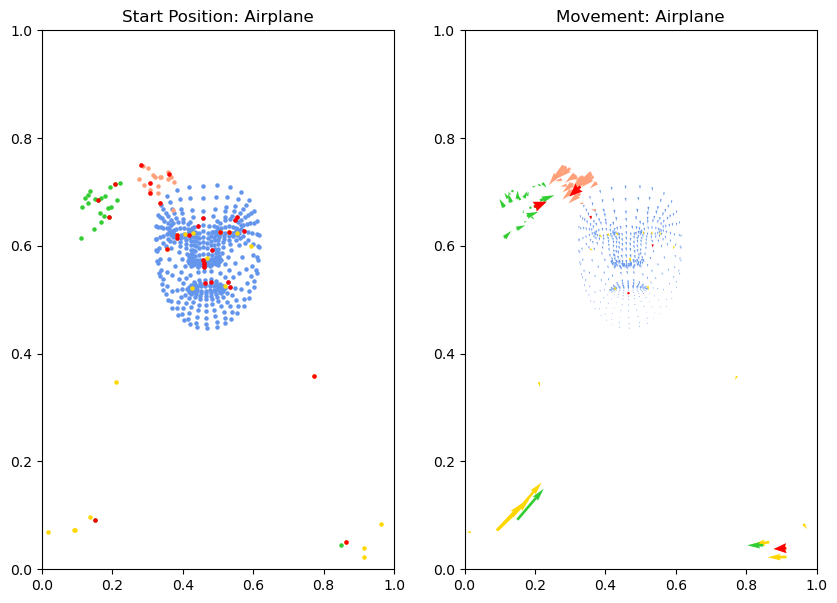

In [466]:
sign_query = 'dad'
sign_query_res = airplane_test
sign_query_res.rename(columns={old:new for old, new in zip(sign_query_res.columns,col_names_fixed[:-1])}, inplace=True)

colors=['cornflowerblue','gold','limegreen','lightsalmon']
titles = ['Start Position: Airplane', 'Movement: Airplane']
ax_id = {'p':0,'d':1}

cols = list(sign_query_res.columns)
px_keep = [col.split('_')[0] != 'px' for col in cols]
dx_keep = [col.split('_')[0] != 'dx' for col in cols]
py_keep = [col.split('_')[0] != 'py' for col in cols]
dy_keep = [col.split('_')[0] != 'dy' for col in cols]
face_keep = [col.split('_')[-1] != 'face' for col in cols]
pose_keep = [col.split('_')[-1] != 'pose' for col in cols]
rh_keep = [col.split('_')[-2] != 'right' for col in cols]
lh_keep = [col.split('_')[-2] != 'left' for col in cols]
types = [face_keep,lh_keep,pose_keep,rh_keep]
type_name = ['face','left_hand','pose','right_hand']

fig, axes = plt.subplots(ncols=2,figsize=(10,7))
for type_i, type_keep in enumerate(types):
    # Vector origin location
    X = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if px_keep[i] or type_keep[i]]).mean().values
    Y = 1-sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if py_keep[i] or type_keep[i]]).mean().values
    
    # Directional vectors
    U = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dx_keep[i] or type_keep[i]]).mean().values
    V = -sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dy_keep[i] or type_keep[i]]).mean().values
    # Creating plot
    axes[0].scatter(X,Y, c=colors[type_i], label=type_name[type_i],s=5)
    axes[1].quiver(X, Y, U, V, color=colors[type_i], units='xy', scale=.5, headwidth=2.5, label=type_name[type_i])

for idx in top_imp.index:
    feat = top_imp.loc[idx]
    lm_keep = [col.split('_')[1] != str(feat['landmark']) for col in cols]
    X = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if px_keep[i] or lm_keep[i]]).mean().values
    Y = 1-sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if py_keep[i] or lm_keep[i]]).mean().values
    U = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dx_keep[i] or lm_keep[i]]).mean().values
    V = -sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dy_keep[i] or lm_keep[i]]).mean().values
    if feat['kinematic'] == 'p':
        axes[ax_id[feat['kinematic']]].scatter(X,Y,c='red', s=5)
    else:
        axes[ax_id[feat['kinematic']]].quiver(X, Y, U, V, color='red', units='xy', scale=.5, headwidth=4)

for i, ax in enumerate(axes):
    # x-lim and y-lim
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(titles[i])
plt.show()

## Average train top f1-scores

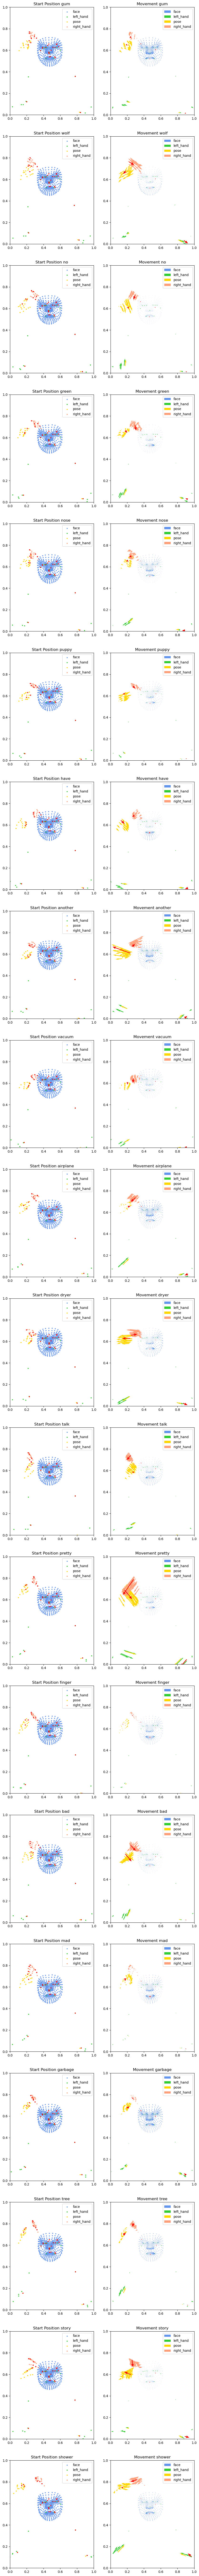

In [255]:
sign_queries = list(hxgb_metrics_df.sort_values(by='f1-score', ascending=False).head(20).index)
sign_query_res = dad_test_set.drop(columns=['sign'])
fig, ax = plt.subplots(nrows=len(sign_queries), ncols=2,figsize=(10,140))

for row, sign_query in enumerate(sign_queries):
    sign_query_res = dataset.loc[dataset.sign == sign_query].drop_duplicates().drop(columns=['sign'])
    # sign_query_res = pd.read_csv('data/dataset_test_hungry.csv', index_col=0).drop(columns=['sign'])
    sign_query_res.rename(columns={old:new for old, new in zip(sign_query_res.columns,col_names_fixed[:-1])}, inplace=True)

    colors=['cornflowerblue','limegreen','gold','lightsalmon']
    titles = [f'Start Position {sign_query}', f'Movement {sign_query}']
    ax_id = {'p':0,'d':1}

    cols = list(sign_query_res.columns)
    px_keep = [col.split('_')[0] != 'px' for col in cols]
    dx_keep = [col.split('_')[0] != 'dx' for col in cols]
    py_keep = [col.split('_')[0] != 'py' for col in cols]
    dy_keep = [col.split('_')[0] != 'dy' for col in cols]
    face_keep = [col.split('_')[-1] != 'face' for col in cols]
    pose_keep = [col.split('_')[-1] != 'pose' for col in cols]
    rh_keep = [col.split('_')[-2] != 'right' for col in cols]
    lh_keep = [col.split('_')[-2] != 'left' for col in cols]
    types = [face_keep,lh_keep,pose_keep,rh_keep]
    type_name = ['face','left_hand','pose','right_hand']
    for type_i, type_keep in enumerate(types):
        # Vector origin location
        X = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if px_keep[i] or type_keep[i]]).mean().values
        Y = 1-sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if py_keep[i] or type_keep[i]]).mean().values
        
        # Directional vectors
        U = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dx_keep[i] or type_keep[i]]).mean().values
        V = -sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dy_keep[i] or type_keep[i]]).mean().values
        # Creating plot
        ax[row][0].scatter(X,Y, c=colors[type_i], label=type_name[type_i],s=5)
        ax[row][1].quiver(X, Y, U, V, color=colors[type_i], units='xy', scale=.5, headwidth=2.5, label=type_name[type_i])

    for idx in top_imp.index:
        feat = top_imp.loc[idx]
        lm_keep = [col.split('_')[1] != str(feat['landmark']) for col in cols]
        X = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if px_keep[i] or lm_keep[i]]).mean().values
        Y = 1-sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if py_keep[i] or lm_keep[i]]).mean().values
        U = sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dx_keep[i] or lm_keep[i]]).mean().values
        V = -sign_query_res.drop(columns=[cols[i] for i in range(len(cols)) if dy_keep[i] or lm_keep[i]]).mean().values
        if feat['kinematic'] == 'p':
            ax[row][ax_id[feat['kinematic']]].scatter(X,Y,c='red', s=5)
        else:
            ax[row][ax_id[feat['kinematic']]].quiver(X, Y, U, V, color='red', units='xy', scale=.5, headwidth=4)

    for i, axe in enumerate(ax[row]):
        # x-lim and y-lim
        axe.set_xlim(0, 1)
        axe.set_ylim(0, 1)

        axe.set_title(titles[i])
        axe.legend()
plt.show()